<a href="https://colab.research.google.com/github/karl-karlsson/notebooks/blob/main/building_a_postgresdb_in_azure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://docs.microsoft.com/sv-se/azure/azure-arc/data/media/postgres-hyperscale/azure-database-for-postgresql-bigger.png)

# Introduction

For this project I wanted to try to build my own PostgreSQL database in Azure.

The data used for this project comes from my bachelor thesis in economics ([link](http://lnu.diva-portal.org/smash/record.jsf?faces-redirect=true&aq2=%5B%5B%5D%5D&af=%5B%5D&searchType=LIST_LATEST&query=&language=sv&pid=diva2%3A1111381&aq=%5B%5B%5D%5D&sf=all&aqe=%5B%5D&sortOrder=author_sort_asc&onlyFullText=false&noOfRows=50&dswid=-5091)   ).

The data consists of three separate `.xls` files that holds information about teams and players in Swedish football between 2007 and 2015 (*). The three `.xls` files are:

* `players.xls`. Data on individual players. For example season, matches played and nationality 
* `results.xls`. Final league standings for different seasons for the highest four divisions in Swedish football
* `teams.xls`. Data on teams. For example attendance numbers and financial data for different teams and seasons. Only for the highest **two** divisions (Allsvenskan and Superettan).

*) For the original project I had data for 2001 - 2015 but I seem to have organized it in a somewhat less than perfect way. So therefore I will use 2007 - 2015 data which I had sort of handu..

# Setting up a database server in Azure

The process of setting up a PostgreSQL server in Azure is quite easy (and also ***free*** up to certain limits with a free account).

I used the Azure portal to spin up the server but if you have an Azure account this can also be done through a command line interface (CLI).

[Here](https://docs.microsoft.com/en-us/azure/postgresql/single-server/tutorial-design-database-using-azure-portal) is a guide you can follow if you want to try it for yourself. It's really quite easy and took me less than five minutes.

# Connect to the server

Once your server is up and running you can find a connection string to your server by clicking on '**Connect**' from the server overview page.

The string has the format:

`"host=servername-somenumbers.postgres.database.azure.com port=port user=username password=password sslmode=require"`

I've stored the connection string to the server as a `.txt` file on my Google Drive for security reasons and acess it with `open(conn_string.txt)` below.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/PostgresProject 

with open('conn_string.txt') as file:
    conn_string = file.readlines()[0]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/PostgresProject


The [`psycopg2`](https://pypi.org/project/psycopg2/) library can be used to run PostegreSQL querys from a Python interface.

In [ ]:
import psycopg2

try:
  conn = psycopg2.connect(conn_string)
except:
  print("Connection failed...")
else:
  print("Connection established!")
  

Connection established!


# Download data using Pandas

## Download player data

In [ ]:
!pip install xlrd==1.2.0  # Pandas require xlrd version > 1.2.0 to read excel files
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
players_xls = pd.read_excel('Data/players.xls')[:11137]
players_xls = players_xls.drop_duplicates()
players_xls[:5]



,Team,PlayerName,Season,Nationality,Region,LaborMarketStatus,YearOfEntry,Matches
0,Ljungskile SK,Aaron Nichols,2013.0,United States,North America,Non EEA,2013.0,8.0
1,Ljungskile SK,Aaron Nichols,2014.0,United States,North America,Non EEA,2013.0,13.0
2,IF Elfsborg,Abbas Hassan,2005.0,Sweden,Sweden,Sweden,NaN,10.0
3,IF Elfsborg,Abbas Hassan,2007.0,Sweden,Sweden,Sweden,NaN,3.0
4,IF Elfsborg,Abbas Hassan,2013.0,Sweden,Sweden,Sweden,NaN,2.0


The `players.xls` file contain the following variables:

* `PlayerId` = a variable indentifying individual players
* `Team` = the team the player played for during the season (can be more than one team for an individual season)
* `PlayerName` =  the name of the player
* `Season` = the year of the season
* `Nationality` =  the nationality (or more specific country of birth) of the player (this data I looked up on www.transfermarkt.com for the original thesis, might not be 100 percent correct)
* `Region` = the region of the country in `Nationality`
* `LaborMarketStatus` = Sweden / EEA / Non EEA where EEA = European Economic Area [wiki](https://en.wikipedia.org/wiki/European_Economic_Area)
* `YearOfEntry` = the first registred season on a Swedish team (if player was born outside Sweden)
* `Matches` = matches played for the `Team` during the specific `Season`

The aim of the original thesis was to investigate differences in salary between Swedish and foreign players and how this changed with for example years since migration and labor market status. 

## Downlaod results data

In [ ]:
results_xls = pd.read_excel('Data/results.xls')
results_xls[:5]

,Season,Team,S,V,O,F,GM-IM,D,P
0,A2016,Malmö FF,30,21,3,6,60-26,34,66
1,A2016,AIK,30,17,9,4,52-26,26,60
2,A2016,IFK Norrköping FK,30,18,6,6,59-37,22,60
3,A2016,IFK Göteborg,30,14,8,8,56-47,9,50
4,A2016,IF Elfsborg,30,13,9,8,58-38,20,48


The `results.xls` file contain the following variables:

* `Season` = a variable indicating league and year. For example 'A2016' means Allsvenskan in 2016 and 'D1S2007' means division 1 south in 2007.
* `Team` = the team name
* `S` = # games played
* `V` = # games won
* `O` = # games drawn
* `F` = # games lost
* `GM-IM` = goals scored (GM) and goals conceded (IM)
* `D` = the goal difference (GM - IM)
* `P` = points (3 p. for wins, 1 p. for draws)

## Download team data



In [ ]:
teams_xls = pd.read_excel('Data/teams.xls')
teams_xls[:5]

,Season,Team,League,rev,cost_total,cost_wages,home_attendance_avg,home_attendance_total
0,2001,AIK,Allsvenskan,53.2,65.2,NaN,15496.0,201448.0
1,2002,AIK,Allsvenskan,71.1,73.3,NaN,16551.0,215163.0
2,2003,AIK,Allsvenskan,65.4,68.8,NaN,17302.0,224926.0
3,2004,AIK,Allsvenskan,54.1,65.4,NaN,13881.0,180447.0
4,2005,AIK,Superettan,44.5,53.1,NaN,11872.0,178075.0


The `teams.xls` file contain the following variables:
* `Season` = the year of the season
* `Team` = the name of the team
* `League` = the league the team played in. Either 'Allsvenskan' or 'Superettan'. Allsvenskan is the first (highest) division of Swedish football and Superettan is the second division.
* `rev` = team revenue for the season in millions SEK (excluding paid transfeer fees)
* `cost_total` = team cost in millions SEK (excluding income from transfer fees)
* `cost_wages` = wage costs for the `Team` during the specific `Season`
* `home_attendance_avg` = the average home attendance for the `Team` during the specific `Season`
* `home_attendance_total` = the total home attendance for the `Team` during the specific `Season`

The data was collected mostly manually in 2017 by copying and pasting different sources such as reports from the Swedish football ass. on the economics of professional soccer [link](https://svff.svenskfotboll.se/om-svff/organisation/ekonomi/).

There are some known errors within the data:

1. In 2011 Örgryte IS filed for bankrupcy and was removed from the league (Superettan)
2. Wage cost are not reported prior to 2009  meaning there are missing values for the `cost_wages` prior to 2009
3. Boden data is missing in original report from SvFF for the season 2005 

For a more thorough description of [see here](http://lnu.diva-portal.org/smash/record.jsf?faces-redirect=true&aq2=%5B%5B%5D%5D&af=%5B%5D&searchType=LIST_LATEST&query=&language=sv&pid=diva2%3A1111381&aq=%5B%5B%5D%5D&sf=all&aqe=%5B%5D&sortOrder=author_sort_asc&onlyFullText=false&noOfRows=50&dswid=-2618).



# Database design

We want to store this data as tables in a database instead of `.xls` files so that we can easliy run querys to extract the output we want. 
The below schema shows how I want to structure these tables on the new database.


![](https://raw.githubusercontent.com/karl-karlsson/data/main/images/design.PNG)

# Data wrangling

### Teams

First I'll create the `Teams` table as a pandas dataframe.
What we want is to find all unique team names and assign a unique Id to each.
We can get this from the `results_xls` dataframe.

In [ ]:
Teams = pd.DataFrame(results_xls.Team.unique())
Teams.columns= ['Name']
Teams["Id"] = Teams.index + 1
Teams = Teams[['Id','Name']]
Teams[:2]

,Id,Name
0,1,Malmö FF
1,2,AIK


Checking datatypes ([see here](https://pbpython.com/pandas_dtypes.html))

In [ ]:
Teams.dtypes

Id       int64
Name    object
dtype: object

Datatypes seem reasonable.

Also check the `shape` of `Teams`

In [ ]:
Teams.shape

(115, 2)

There are 115 unique teams in the table (which I happen to know is correct...). We'll also add a new `TeamId` variable to the old `results_xls` dataframe to make things easier down the road. 

In [ ]:
results_xls = pd.merge(results_xls,Teams,left_on='Team',right_on='Name').iloc[:,:10] # Select only first 10 cols to not include 'Name' from 'Teams'
results_xls.rename(columns = {'Id':'TeamId'}, inplace = True)
results_xls[:2]

,Season,Team,S,V,O,F,GM-IM,D,P,TeamId
0,A2016,Malmö FF,30,21,3,6,60-26,34,66,1
1,A2015,Malmö FF,30,15,9,6,54-34,20,54,1


### LeagueSeason

Lets now create the `LeagueSeason` table.
The table should include year, league name and an unique Id that identifies the row. 



In [ ]:
# Create the year variable as integer from the last 4 characters of the season string
results_xls["Year"] = results_xls.Season.str[-4:].astype(int)

# Create league variable and remover all years ("A2016" --> "A")
results_xls["League"] = results_xls["Season"]
for year in range(2007,2017):
  year = str(year)
  results_xls.League = results_xls.League.str.replace(year,"")

results_xls[:2]

,Season,Team,S,V,O,F,GM-IM,D,P,TeamId,Year,League
0,A2016,Malmö FF,30,21,3,6,60-26,34,66,1,2016,A
1,A2015,Malmö FF,30,15,9,6,54-34,20,54,1,2015,A


In [ ]:
results_xls.League.unique()

array(['A', 'SE', 'D1N', 'D1S'], dtype=object)

In [ ]:
results_xls['League'] = results_xls['League'].str.strip().replace(dict(zip(["A", "SE", "D1N", "D1S"], ["Allsvenskan","Superettan", "Division 1 N.", "Division 1 S."])),regex=True)
results_xls[:2]

,Season,Team,S,V,O,F,GM-IM,D,P,TeamId,Year,League
0,A2016,Malmö FF,30,21,3,6,60-26,34,66,1,2016,Allsvenskan
1,A2015,Malmö FF,30,15,9,6,54-34,20,54,1,2015,Allsvenskan


In [ ]:
LeagueSeason = results_xls[["Year","League","Season"]].drop_duplicates()
LeagueSeason['Id'] = LeagueSeason.groupby(['Year','League']).ngroup()+1
LeagueSeason = LeagueSeason.sort_values("Id")
LeagueSeason = LeagueSeason[["Id","League","Year"]]
LeagueSeason[:2]

,Id,League,Year
9,1,Allsvenskan,2007
78,2,Division 1 N.,2007


Checking datatypes

In [ ]:
LeagueSeason.dtypes

Id         int64
League    object
Year       int64
dtype: object

`Id` and `Year` should be integers and `League` is a string for which `dtype = object` is correct.

In [ ]:
results_xls = pd.merge(results_xls,LeagueSeason,on=['League','Year'])
results_xls.rename(columns = {'Id':'LeagueSeasonId'}, inplace = True)
results_xls[:2]

,Season,Team,S,V,O,F,GM-IM,D,P,TeamId,Year,League,LeagueSeasonId
0,A2016,Malmö FF,30,21,3,6,60-26,34,66,1,2016,Allsvenskan,37
1,A2016,AIK,30,17,9,4,52-26,26,60,2,2016,Allsvenskan,37


### Countries

In [ ]:
Countries = players_xls[["Nationality","Region"]].drop_duplicates()
Countries['Id'] = Countries.groupby(['Nationality']).ngroup()+1 #Grouping by also Season to keep track of EU membership, could of course be in a table of itself
Countries = Countries.sort_values("Id")
Countries = Countries[["Id","Nationality","Region"]]

In [ ]:
cols_to_use = players_xls.columns.difference(Countries.columns).tolist()
cols_to_use.append("Nationality")
players_xls = pd.merge(players_xls[cols_to_use],Countries,on='Nationality')
players_xls[:2]

,LaborMarketStatus,Matches,PlayerName,Season,Team,YearOfEntry,Nationality,Id,Region
0,Non EEA,8.0,Aaron Nichols,2013.0,Ljungskile SK,2013.0,United States,97,North America
1,Non EEA,13.0,Aaron Nichols,2014.0,Ljungskile SK,2013.0,United States,97,North America


In [ ]:
Countries[:2]

,Id,Nationality,Region
11136,0,NaN,NaN
1187,1,Albania,Eastern Europe


In [ ]:
Countries.dtypes

Id              int64
Nationality    object
Region         object
dtype: object

Correct datatypes.

In [ ]:
players_xls.rename(columns = {'Id':'CountryId','Season':'Year'}, inplace = True)
players_xls.drop(columns=["Nationality","Region","LaborMarketStatus"], inplace=True)
players_xls[:2]

,Matches,PlayerName,Year,Team,YearOfEntry,CountryId
0,8.0,Aaron Nichols,2013.0,Ljungskile SK,2013.0,97
1,13.0,Aaron Nichols,2014.0,Ljungskile SK,2013.0,97


### PlayerGames

First we will create a column for `PlayerId`.
We'll assume that any player coming from the same country with the same name is an unique player (this might introduce some irregularities for Swedish players with some common name but we'll just ignore this for now). 

In [ ]:
players_xls['PlayerId'] = players_xls.groupby(["PlayerName", "CountryId"]).ngroup()+1

players_xls[:2]

,Matches,PlayerName,Year,Team,YearOfEntry,CountryId,PlayerId
0,8.0,Aaron Nichols,2013.0,Ljungskile SK,2013.0,97,1
1,13.0,Aaron Nichols,2014.0,Ljungskile SK,2013.0,97,1


In [ ]:

PlayerGames = pd.merge(players_xls,results_xls,on=['Team','Year'])
PlayerGames = PlayerGames[["PlayerId","Matches","TeamId","LeagueSeasonId"]]
PlayerGames[:3]

,PlayerId,Matches,TeamId,LeagueSeasonId
0,1,8.0,27,28
1,2675,28.0,27,28
2,2677,6.0,27,28


In [ ]:
PlayerGames.dtypes

PlayerId            int64
Matches           float64
TeamId              int64
LeagueSeasonId      int64
dtype: object

`Matches` shouldn't be a `float` and netiher should `PlayerId`. In the dataset players can't play fractions of matches so there's no need for decimals. We'll convert to `int64` for both.

In [ ]:
PlayerGames = PlayerGames.astype({'Matches': 'int64',
                                  'PlayerId':'int64'})
PlayerGames.dtypes

PlayerId          int64
Matches           int64
TeamId            int64
LeagueSeasonId    int64
dtype: object

### PlayerAttributes

In [ ]:
PlayerAttributes = players_xls[["PlayerId","PlayerName","YearOfEntry","CountryId"]].drop_duplicates()
PlayerAttributes.sort_values("PlayerId", inplace=True)
PlayerAttributes[:5]

,PlayerId,PlayerName,YearOfEntry,CountryId
11076,0,NaN,NaN,0
0,1,Aaron Nichols,2013.0,97
71,2,Abbas Hassan,NaN,88
8813,3,Abdel Bouraima,2013.0,11
8821,4,Abderrahman Kabous,2005.0,65


In [ ]:
PlayerAttributes.dtypes

PlayerId         int64
PlayerName      object
YearOfEntry    float64
CountryId        int64
dtype: object

Ideally `YearOfEntry` should be of type integer but because ofsome problems with how `Pandas` integrate with `psycopg2` with respect to `NULL` values we'll just leave it as float for now and fix later.

But we'll change `PlayerId` to `int`.





In [ ]:
PlayerAttributes = PlayerAttributes.astype({'PlayerId': 'int64'})
PlayerAttributes.dtypes

PlayerId         int64
PlayerName      object
YearOfEntry    float64
CountryId        int64
dtype: object

### Results

In [ ]:
Results = results_xls
Results['GoalsScored'] = results_xls['GM-IM'].str.rsplit('-', expand=True)[0]
Results['GoalsConceded'] = results_xls['GM-IM'].str.rsplit('-', expand=True)[1]


Results.rename(columns = {'S':'GamesPlayed','V':'Won','O':'Draw','F':'Lost',"P":"Points"}, inplace = True)
Results = Results[['GamesPlayed','Won','Draw','Lost','GoalsScored','GoalsConceded','Points','TeamId','LeagueSeasonId']]
Results[:2]

,GamesPlayed,Won,Draw,Lost,GoalsScored,GoalsConceded,Points,TeamId,LeagueSeasonId
0,30,21,3,6,60,26,66,1,37
1,30,17,9,4,52,26,60,2,37


In [ ]:
Results.dtypes

GamesPlayed        int64
Won                int64
Draw               int64
Lost               int64
GoalsScored       object
GoalsConceded     object
Points             int64
TeamId             int64
LeagueSeasonId     int64
dtype: object

Looks OK...

### Finances

In [ ]:
Finances = results_xls
Finances = Finances[['Team','Year','League','TeamId','LeagueSeasonId']]
Finances.rename(columns = {'Year':'Season'}, inplace = True)
Finances = pd.merge(Finances,teams_xls,on=['Team','Season','League'])
Finances.rename(columns = {'rev':'Revenue','cost_total':'Cost','cost_wages':'WageCost','home_attendance_total':'HomeAttendanceTotal'}, inplace = True)
Finances = Finances[['Revenue','Cost','WageCost','HomeAttendanceTotal','TeamId','LeagueSeasonId']]
Finances[:2]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Revenue,Cost,WageCost,HomeAttendanceTotal,TeamId,LeagueSeasonId
0,137.0,157.9,68.500,314750.0,2,33
1,99.1,103.2,50.541,138579.0,5,33


In [ ]:
Finances.dtypes

Revenue                float64
Cost                   float64
WageCost               float64
HomeAttendanceTotal    float64
TeamId                   int64
LeagueSeasonId           int64
dtype: object

`Revenue`, `Cost` and `WageCost` should be `floats`. But `HomeAttendanceTotal` should be of type `int` since not half a person can attend a game. 

In [ ]:
Finances = Finances.astype({'HomeAttendanceTotal': 'int64'})
Finances.dtypes

Revenue                float64
Cost                   float64
WageCost               float64
HomeAttendanceTotal      int64
TeamId                   int64
LeagueSeasonId           int64
dtype: object

# Creating a database on the server

Let's start by creating a database (`football.db`) on the server.
Into `football.db` we'll later insert our created dataframes as tables.

The first step is to create a `cursor` object using the `connection` object `conn` we created while connecting to the server.

In [ ]:
cur = conn.cursor()
conn.autocommit = True

In [ ]:
# This is need for creating a database

cur.execute('''
CREATE DATABASE football;
''')


Let's see if the new database exits.

In [ ]:
cur.execute('''
SELECT datname FROM pg_database;
''')

cur.fetchall()

[('azure_maintenance',),
 ('template1',),
 ('postgres',),
 ('template0',),
 ('azure_sys',),
 ('football',)]

It does!

We'll add the `dbname=football` to the `conn_string` so that we're working in the right database.

In [ ]:
conn_string = conn_string + " dbname=football"
conn.close()

try:
  conn = psycopg2.connect(conn_string)
except:
  print("Connection failed...")
else:
  print("Connection established!")

Connection established!


In [ ]:
cur = conn.cursor()
conn.autocommit = True

# Inserting data into tables

To insert data into tables we'll do three things for each table.

* Create the new table
* Convert pandas dataframes to `.csv`
* Use the `cursor.copy_from()` method

We'll start by defining a function that takes care of the last two.

In [ ]:

def football_insert(Table):
  filename = Table+".csv"
  eval(Table).to_csv(filename, index=False, header=False)
  with open(filename) as file :
    cur.copy_from(file, Table, sep=',')
  
  cur.execute("SELECT * FROM "+Table+" LIMIT 5;")
  print("Insertion succesfull. First five rows:\n")
  return cur.fetchall()


## `Teams`

Now we can create our first table. This is the `Teams` table.
We'll first create the table itself and then insert the data from the dataframe.

In [ ]:
cur.execute("""
CREATE TABLE Teams(
  Id INTEGER PRIMARY KEY,
  Name TEXT
);
""")

In [ ]:
football_insert("Teams")

Insertion succesfull. First five rows:



[(1, 'Malmö FF'),
 (2, 'AIK'),
 (3, 'IFK Norrköping FK'),
 (4, 'IFK Göteborg'),
 (5, 'IF Elfsborg')]

## `LeagueSeason` and `Countries`

Rinse and repeat...

In [ ]:
cur.execute("""
CREATE TABLE LeagueSeason(
  Id INTEGER PRIMARY KEY,
  LeagueName TEXT,
  Year TEXT
);
""")

football_insert("LeagueSeason")

Insertion succesfull. First five rows:



/usr/local/lib/python3.7/dist-packages/IPython/core/displayhook.py:260: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


[(1, 'Allsvenskan', '2007'),
 (2, 'Division 1 N.', '2007'),
 (3, 'Division 1 S.', '2007'),
 (4, 'Superettan', '2007'),
 (5, 'Allsvenskan', '2008')]

In [ ]:
cur.execute("""
CREATE TABLE Countries(
Id INTEGER PRIMARY KEY,
Name TEXT,
Region TEXT
);
""")

football_insert("Countries")

Insertion succesfull. First five rows:



[(0, '', ''),
 (1, 'Albania', 'Eastern Europe'),
 (2, 'Algeria', 'Africa'),
 (3, 'Angola', 'Africa'),
 (4, 'Argentina', 'South America')]

## `Finances` and `Results`
The `Finances` and `Results` tables hold compund primary keys (`TeamId` and `LeagueSeasonId`). The syntax for this slightly different but the process is the same.

Also, because there are some `NaN` values for the WageCost column in the `Finances` table we will temporarily code them as `999` and replace them with `NULL` values with a proper SQL statement in the final table.

( There's perhaps a better way to do this but this works for this purpose )

In [ ]:
# Replace all NA/NaN with 999
Finances = Finances.fillna(psycopg2.extensions.AsIs(999))

In [ ]:
# NUMERIC(5,2) means precision=5 and scale=2 where precision is number of digits in total and scale is maximum number of digits after decimal point

cur.execute("""
CREATE TABLE Finances(
Revenue NUMERIC(5,2),
Cost NUMERIC(5,2),
WageCost NUMERIC(5,2),
HomeAttendanceTotal INTEGER,
TeamId INTEGER,
LeagueSeasonId INTEGER,
PRIMARY KEY(TeamId, LeagueSeasonId)
);
""")

football_insert("Finances")

Insertion succesfull. First five rows:



[(Decimal('137.00'), Decimal('157.90'), Decimal('68.50'), 314750, 2, 33),
 (Decimal('99.10'), Decimal('103.20'), Decimal('50.54'), 138579, 5, 33),
 (Decimal('57.30'), Decimal('74.40'), Decimal('39.54'), 92443, 6, 33),
 (Decimal('93.20'), Decimal('87.30'), Decimal('46.60'), 382607, 11, 33),
 (Decimal('36.00'), Decimal('40.10'), Decimal('21.60'), 75749, 13, 33)]

In [ ]:
# Updating to NULL values where WageCost = 999

cur.execute("""
UPDATE Finances
SET WageCost = NULL
WHERE WageCost=999;
""")

cur.execute("""
SELECT *
FROM Finances
WHERE WageCost IS NULL
LIMIT 5;
""")

cur.fetchall()

[(Decimal('97.60'), Decimal('113.30'), None, 233025, 2, 5),
 (Decimal('73.10'), Decimal('77.20'), None, 142697, 5, 5),
 (Decimal('54.20'), Decimal('45.80'), None, 91539, 6, 5),
 (Decimal('70.30'), Decimal('89.90'), None, 167167, 11, 5),
 (Decimal('48.40'), Decimal('40.10'), None, 68948, 13, 5)]

In [ ]:
cur.execute("""
CREATE TABLE Results(
GamesPlayed INTEGER,
Won INTEGER,
Draw INTEGER,
Lost INTEGER,
GoalsScored INTEGER,
GoalsConceded INTEGER,
Points INTEGER,
TeamId INTEGER,
LeagueSeasonId INTEGER,
PRIMARY KEY(TeamId, LeagueSeasonId)
);
""")

football_insert("Results")

Insertion succesfull. First five rows:



[(30, 21, 3, 6, 60, 26, 66, 1, 37),
 (30, 17, 9, 4, 52, 26, 60, 2, 37),
 (30, 18, 6, 6, 59, 37, 60, 3, 37),
 (30, 14, 8, 8, 56, 47, 50, 4, 37),
 (30, 13, 9, 8, 58, 38, 48, 5, 37)]

## PlayerAttributes

PlayerAttributes and PlayerGames hold foreign keys aswell. There are also some `NaN` values in the `YearOfEntry` column for players born in Sweden.

In [ ]:
PlayerAttributes.dtypes

PlayerId         int64
PlayerName      object
YearOfEntry    float64
CountryId        int64
dtype: object

In [ ]:
# Replace all NA/NaN with 999
PlayerAttributes = PlayerAttributes.fillna(psycopg2.extensions.AsIs(9999))

In [ ]:
cur.execute("""
CREATE TABLE PlayerAttributes(
PlayerId INTEGER PRIMARY KEY,
Name TEXT,
YearOfEntry NUMERIC(4,0),
CountryId INTEGER,
FOREIGN KEY(CountryId) REFERENCES Countries(Id)
);
""")

football_insert("PlayerAttributes")

Insertion succesfull. First five rows:



[(0, '9999', Decimal('9999'), 0),
 (1, 'Aaron Nichols', Decimal('2013'), 97),
 (2, 'Abbas Hassan', Decimal('9999'), 88),
 (3, 'Abdel Bouraima', Decimal('2013'), 11),
 (4, 'Abderrahman Kabous', Decimal('2005'), 65)]

In [ ]:
# Updating to NULL values where YearOfEntry = 0999

cur.execute("""
UPDATE PlayerAttributes
SET YearOfEntry = NULL
WHERE YearOfEntry=9999;
""")

cur.execute("""
SELECT *
FROM PlayerAttributes
WHERE YearOfEntry IS NULL
LIMIT 5;
""")


## PlayerGames


In [ ]:
cur.execute("""
CREATE TABLE PlayerGames(
PlayerId INTEGER,
GamesPlayed INTEGER,
TeamId INTEGER,
LeagueSeasonId INTEGER,
PRIMARY KEY(PlayerId, TeamId, LeagueSeasonId),
FOREIGN KEY(TeamId) REFERENCES Teams(Id),
FOREIGN KEY(LeagueSeasonId) REFERENCES LeagueSeason(Id)
);
""")

football_insert("PlayerGames")

Insertion succesfull. First five rows:



[(1, 8, 27, 28),
 (2675, 28, 27, 28),
 (2677, 6, 27, 28),
 (2722, 12, 27, 28),
 (153, 26, 27, 28)]

Thats it! Now we have all of ours tables on the PostgreSQL server on Azure.

In [ ]:
cur.execute("""
SELECT *
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog' AND 
    schemaname != 'information_schema';
""")

cur.fetchall()

[('public', 'finances', 'postgres', None, True, False, False, False),
 ('public', 'results', 'postgres', None, True, False, False, False),
 ('public', 'countries', 'postgres', None, True, False, True, False),
 ('public', 'playerattributes', 'postgres', None, True, False, True, False),
 ('public', 'teams', 'postgres', None, True, False, True, False),
 ('public', 'playergames', 'postgres', None, True, False, True, False),
 ('public', 'leagueseason', 'postgres', None, True, False, True, False)]

# Running querys on the new database (change to an interesting question instead?)

Now that we have all of our tables we can run some interesting querys.

For this I will use an alternative way to fetch the output which is the `pandas.read_sql()` method. This way we get the output as a dataframe which besides being easier to read also can be used directly for visualizations.

### Which team won allsvenskan the most times between 2007 and 2016


In [ ]:
sql = """
WITH 
winners AS
(
SELECT 
  leagueseasonid, 
  MAX(points) AS points
FROM Results
GROUP BY leagueseasonid
)

SELECT 
  t.name AS team,
  COUNT(*) AS winners
FROM winners AS w
LEFT JOIN results AS r ON w.leagueseasonid = r.leagueseasonid AND
w.points = r.points
LEFT JOIN leagueseason AS ls ON w.leagueseasonid = ls.id
LEFT JOIN teams AS t ON r.teamid = t.id
WHERE leaguename = 'Allsvenskan'
GROUP BY name
ORDER BY winners DESC;
;
"""

In [ ]:
pd.read_sql(sql, conn)

,team,winners
0,Malmö FF,4
1,Helsingborgs IF,1
2,IF Elfsborg,1
3,AIK,1
4,IFK Norrköping FK,1
5,Kalmar FF,1
6,IFK Göteborg,1


Malmö FF was the best club by far. Winning the championship four times... 

## Which individual player have won the most times?

In [ ]:
sql = """
WITH 
winners AS
(
SELECT 
  leagueseasonid, 
  MAX(points) AS points
FROM Results
GROUP BY leagueseasonid
)

SELECT 
  pa.name,
  COUNT(*) AS winner 
FROM winners AS w
LEFT JOIN results AS r ON w.leagueseasonid = r.leagueseasonid AND
w.points = r.points
LEFT JOIN leagueseason AS ls ON w.leagueseasonid = ls.id
LEFT JOIN teams AS t ON r.teamid = t.id
INNER JOIN playergames AS pg ON t.id=pg.teamid AND w.leagueseasonid=pg.leagueseasonid
INNER JOIN playerattributes AS pa ON pg.playerid=pa.playerid
WHERE leaguename = 'Allsvenskan'
GROUP BY pa.name
ORDER by winner DESC
LIMIT 5
;
"""

In [ ]:
pd.read_sql(sql, conn)

,name,winner
0,Stefan Larsson,2
1,David Elm,2
2,Alvaro Santos,1
3,Anders Svensson,1
4,Amadou Jawo,1


According to this data only two players managed to win Allsvenskan two times between 2007 and 2016. Stefan Larsson and David Elm.

Funny fact is that they both played for the same two clubs when doin so. Both played for Kalmar FF when they won in 2008 and both played for IF Elfsborg when they won in 2012.

## How did the average revenue figures changed for Allsvenskan and Superettan between X and Y? 



In [ ]:
sql = """

SELECT 
    AVG(Revenue) AS revenue,
    ls.id,
    ls.leaguename,
    ls.year
    FROM finances AS f
    LEFT JOIN LeagueSeason AS ls ON f.leagueseasonid = ls.id
    GROUP BY ls.id
;
"""

In [ ]:
revenue = pd.read_sql(sql, conn)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


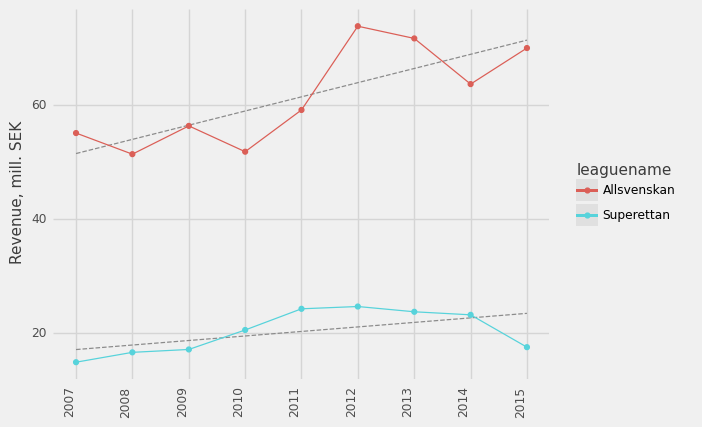

<ggplot: (8763291678909)>

In [ ]:
import plotnine as gg
from mizani.breaks import date_breaks
from mizani.formatters import date_format

(
gg.ggplot(revenue, gg.aes(x='year', y='revenue', group="leaguename", color="leaguename"))
+gg.geom_smooth(method='lm', se=False, linetype='dashed', size=1/2, color="#8b8b8b")
+gg.geom_line()
+gg.geom_point()
+gg.scales.scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y')) 
+gg.themes.theme_538()
+gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=1))
+gg.labs(x="", y="Revenue, mill. SEK")
)

Revenue rose in both leages over the time period but more so for Allsvenskan compared to Superettan.

# Conclusions

In this project I:

* Created my own PostgreSQL server on the Microsoft Azure cloud
* Designed my own database
* Used Python to insert data from `.xls` files

Performed some analysis to learn that:

* Malmö FF was the best team with 4 wins during the time period
* David Elm and Stefan Larsson won allsvenskan the most times during the period
* Revenues increased for clubs in Allsvenskan between 2007 and 2016

# Contact details

![bild](https://avatars.githubusercontent.com/u/99097833?v=4)

Feel free to reach out:

* Twitter: [@vaxjo_kalle](https://twitter.com/vaxjo_kalle) 
* LinkedIn: [My profile](https://www.linkedin.com/in/karlkarlssonvaxjo/)
* E-mail: [karl_karlsson@icloud.com](mailto:karl_karlsson@icloud.com)
* GitHub: [github.com/karl-karlsson](https://github.com/karl-karlsson)

# Delete database and close conn

In [ ]:
conn.close()

with open('conn_string.txt') as file:
    conn_string = file.readlines()[0]

conn = psycopg2.connect(conn_string)
conn.autocommit = True
cur = conn.cursor()

cur.execute("""DROP DATABASE football;""")

conn.close()